<a href="https://colab.research.google.com/github/austinbennysmith/CMIP6/blob/main/maps_ssp585.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This code graphs the difference between Sahel rainfall in the last and first decade of the 21st century in SSP5-8.5 simulations from the CMIP6 archive (split up by season). It takes the average across all ensemble members for any model chosen and maps that average.

In [ ]:
# Some installations and imports:
!pip install fsspec
!pip install netCDF4
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
!pip install eofs
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
from eofs.xarray import Eof
from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
import cftime
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/EEPS_1430/EEPS 1430 Final Project/images'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
# Reading in the CSV file and querying for the particular data that I want (this can be changed for whichever models, activities, experiments etc. you want to look at)
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
ssp585 = df.query("variable_id == 'pr' & experiment_id == 'ssp585' & table_id == 'Amon' & source_id == 'CESM2'")
experiment_id = 'ssp585'
source_id = 'CESM2'
memnum = '3'
ssp585

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
348670,ScenarioMIP,NCAR,CESM2,ssp585,r10i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/NCAR/CESM2/ssp585/r10i1...,NaN,20200528
348773,ScenarioMIP,NCAR,CESM2,ssp585,r11i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/NCAR/CESM2/ssp585/r11i1...,NaN,20200528
348872,ScenarioMIP,NCAR,CESM2,ssp585,r4i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/NCAR/CESM2/ssp585/r4i1p...,NaN,20200528


In [ ]:
# df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# ssp585 = df.query("variable_id == 'pr' & experiment_id == 'ssp534-over' & table_id == 'Amon' & source_id == 'EC-Earth3'")
# experiment_id = 'ssp534-over'
# source_id = 'EC-Earth3'
# memnum = '50'
# ssp585

In [3]:
# The following code just prints the number of ensemble members for each model for reference
ssp = df.query("variable_id == 'pr' & experiment_id == 'ssp585' & table_id == 'Amon'")
unique_sources = []
for i in ssp['source_id']:
  if i not in unique_sources:
    unique_sources.append(i)
print(unique_sources)

for i in unique_sources:
  x = ssp.query("source_id =="+"'"+i+"'")
  print(str(len(x))+': '+i)

['TaiESM1', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-f3-L', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'IITM-ESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'E3SM-1-1', 'EC-Earth3-Veg-LR', 'EC-Earth3-Veg', 'EC-Earth3', 'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2-WACCM', 'CESM2', 'NorESM2-LM', 'NorESM2-MM', 'KACE-1-0-G', 'GFDL-CM4', 'GFDL-ESM4', 'NESM3', 'CIESM', 'MCM-UA-1-0']
1: TaiESM1
1: AWI-CM-1-1-MR
1: BCC-CSM2-MR
2: CAMS-CSM1-0
1: FGOALS-f3-L
4: FGOALS-g3
3: CanESM5-CanOE
50: CanESM5
1: IITM-ESM
1: CMCC-CM2-SR5
1: CNRM-CM6-1-HR
6: CNRM-CM6-1
5: CNRM-ESM2-1
3: ACCESS-CM2
10: ACCESS-ESM1-5
2: MPI-ESM1-2-HR
1: E3SM-1-1
3: EC-Earth3-Veg-LR
6: EC-Earth3-Veg
58: EC-Earth3
3: FIO-ESM-2-0
1: INM-CM4-8
1: INM-CM5-0
6: IPSL-CM6A-LR
1: MIROC-ES2L
50: MIROC6
4: HadGEM3-GC31

In [4]:
# Slicing and dicing the data for analysis:
all_maps = []
keyslist = ['DJF', 'MAM', 'JJA', 'SON']

# Useful stackexchange post: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
def is_djf(month):
  return (month>=12) | ((month>=1) & (month<=2))
def is_mam(month):
  return (month>=3) & (month<=5)
def is_jja(month):
  return (month>=6) & (month<=8)
def is_son(month):
  return (month>=9) & (month<=11)

for z in range(len(ssp585.zstore.values)):
  print(z)
  # Accessing the file, getting it to just the lats and lons I want:
  zstore = ssp585.zstore.values[z]
  mapper = fsspec.get_mapper(zstore)
  ds = xr.open_zarr(mapper, consolidated=True, decode_times=True)
  # pr = ds.pr.sel(lat=slice(11.25,18.75))
  pr = ds.pr.sel(lat=slice(0,40))
  pr = pr.where((ds.lon >= 343.12) | (ds.lon <= 39.38), drop=True)
  # lat = ds.lat.sel(lat=slice(11.25,18.75))
  lat = ds.lat.sel(lat=slice(0,40))
  lon = ds.lon.where((ds.lon >= 343.12) | (ds.lon <= 39.38), drop=True) # Not sure exactly what drop means, but I think it doesn't matter

  pr_djf = pr.sel(time=is_djf(pr['time.month']))
  pr_mam = pr.sel(time=is_mam(pr['time.month']))
  pr_jja = pr.sel(time=is_jja(pr['time.month']))
  pr_son = pr.sel(time=is_son(pr['time.month']))


  pr_allseasons = {
      'DJF': pr_djf,
      'MAM': pr_mam,
      'JJA': pr_jja,
      'SON': pr_son
  }
  # Splitting it up by decade:
  decades = np.arange(2010, 2110, 10)
  decade_list = [] # I'll use decade_list for graphing.
  for i in range(len(decades)):
    if i<(len(decades)-1):
      decade_list.append(str(decades[i])+'-'+str(decades[i+1]))
  decade_list[0] = '2015-2020'

  def in_decade(minyear, maxyear, year):
    return (year>=minyear) & (year<maxyear)
  pr_FINAL = {
      'DJF': [],
      'MAM': [],
      'JJA': [],
      'SON': []
  }
  for j in pr_allseasons.keys():
    for i in range(1, len(decades)):
      pr_FINAL[j].append(pr_allseasons[j].sel(time=in_decade(decades[i-1], decades[i], pr_allseasons[j]['time.year'])))

  time_avg_dict = {
      'DJF': [],
      'MAM': [],
      'JJA': [],
      'SON': []
  }
  map_dict = {
      'DJF': [],
      'MAM': [],
      'JJA': [],
      'SON': []
  }
  for season in keyslist:
    for i in range(9):
      map_dict[season].append(pr_FINAL[season][i].mean(axis=0))

  all_maps.append(map_dict)

0
1
2


/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


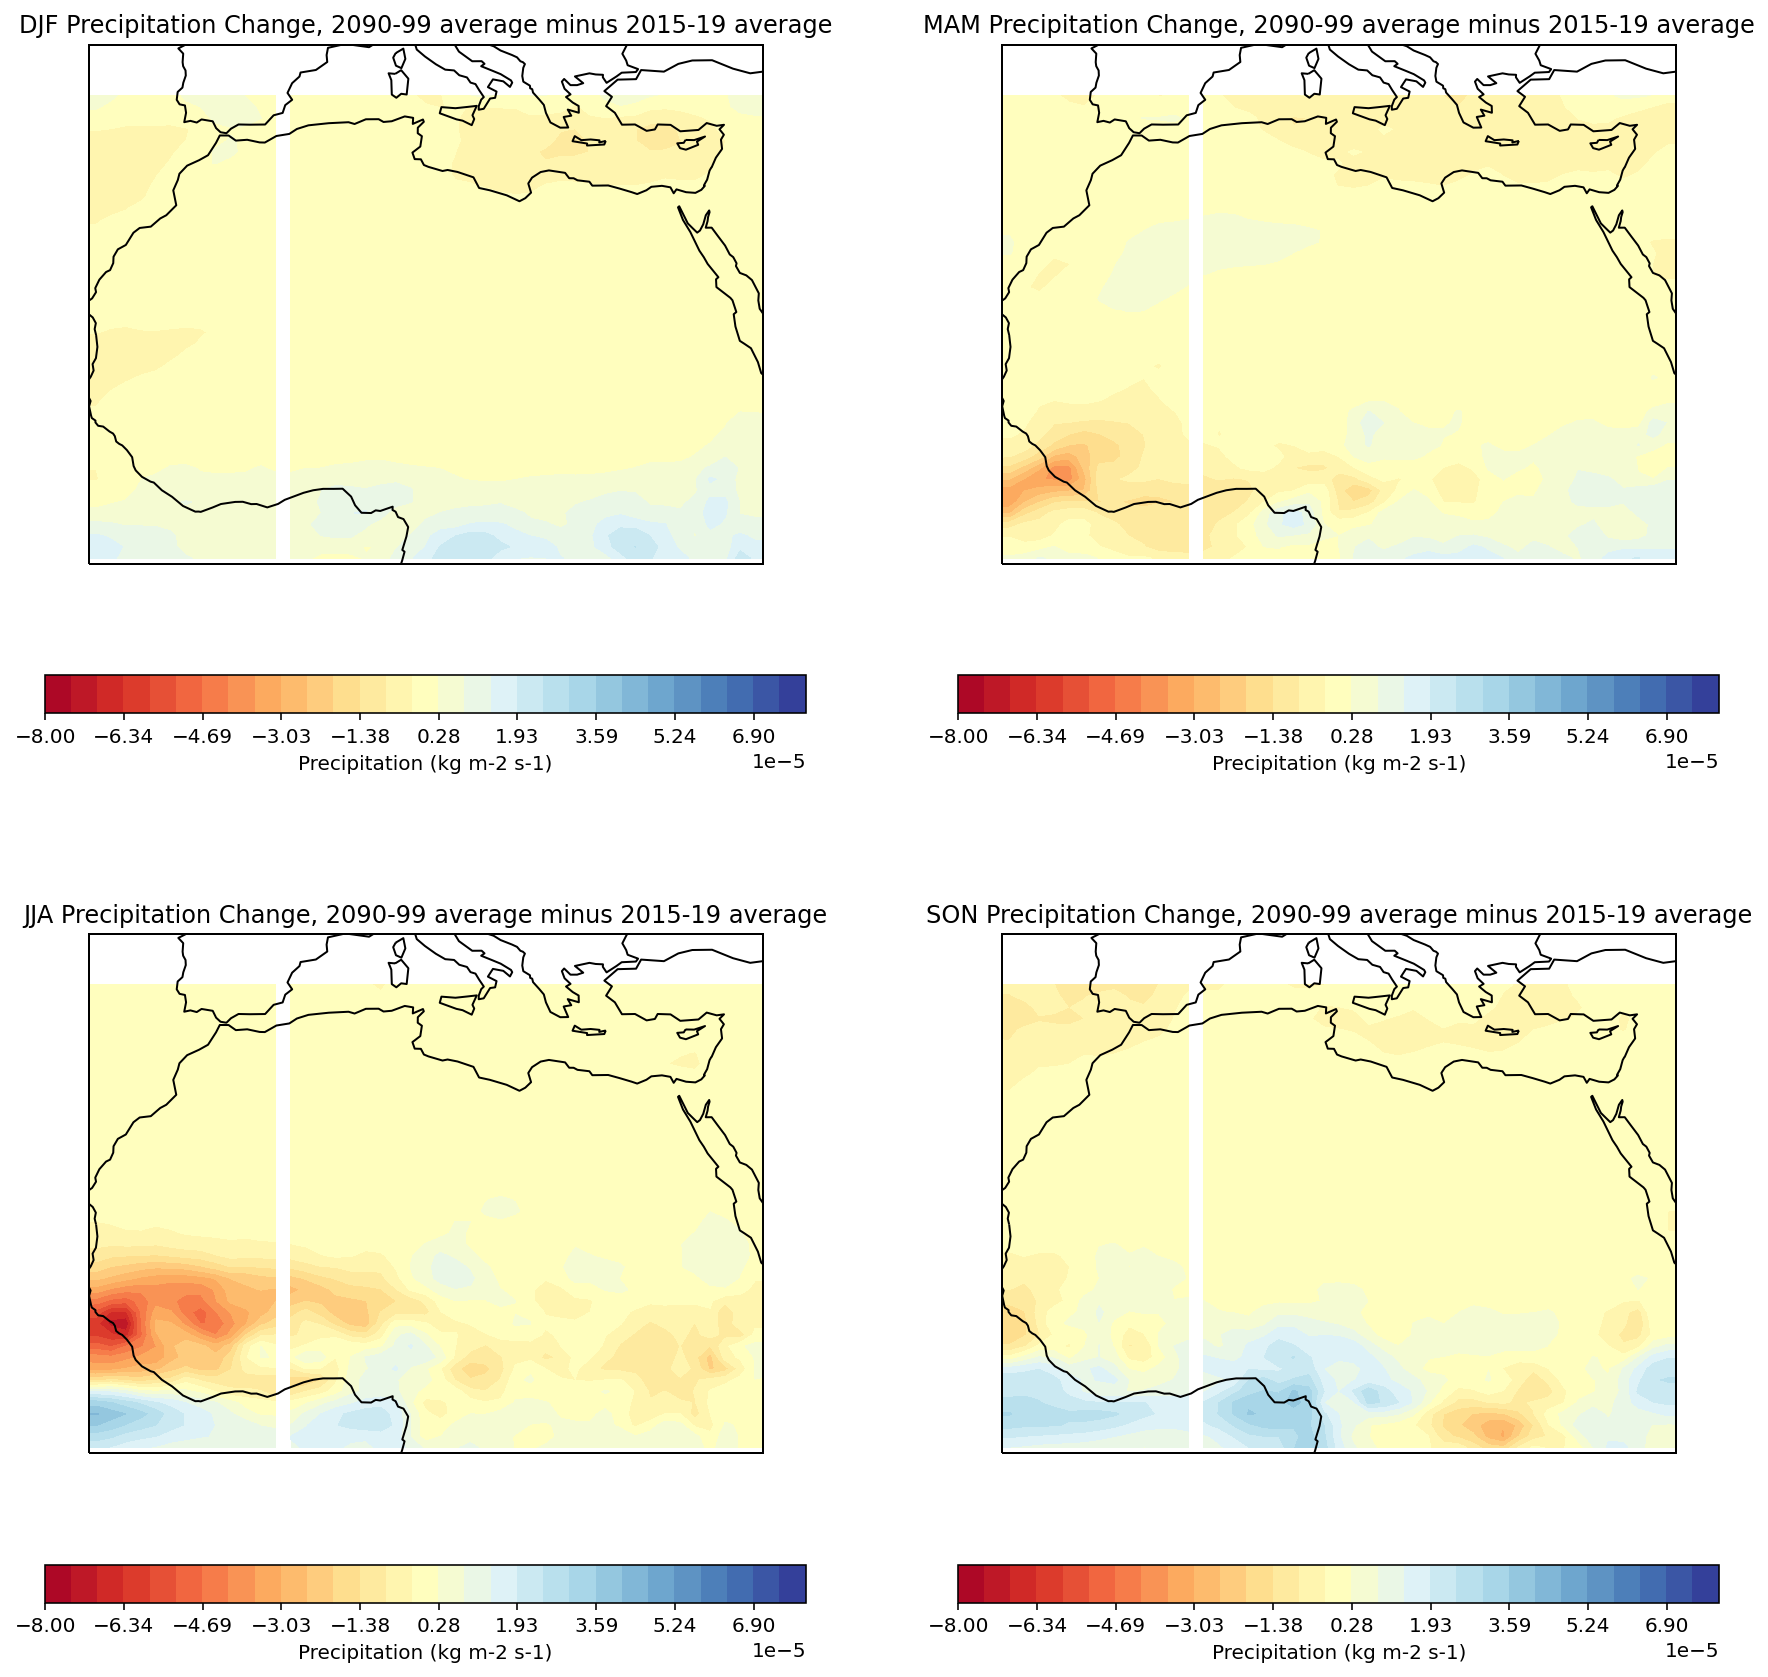

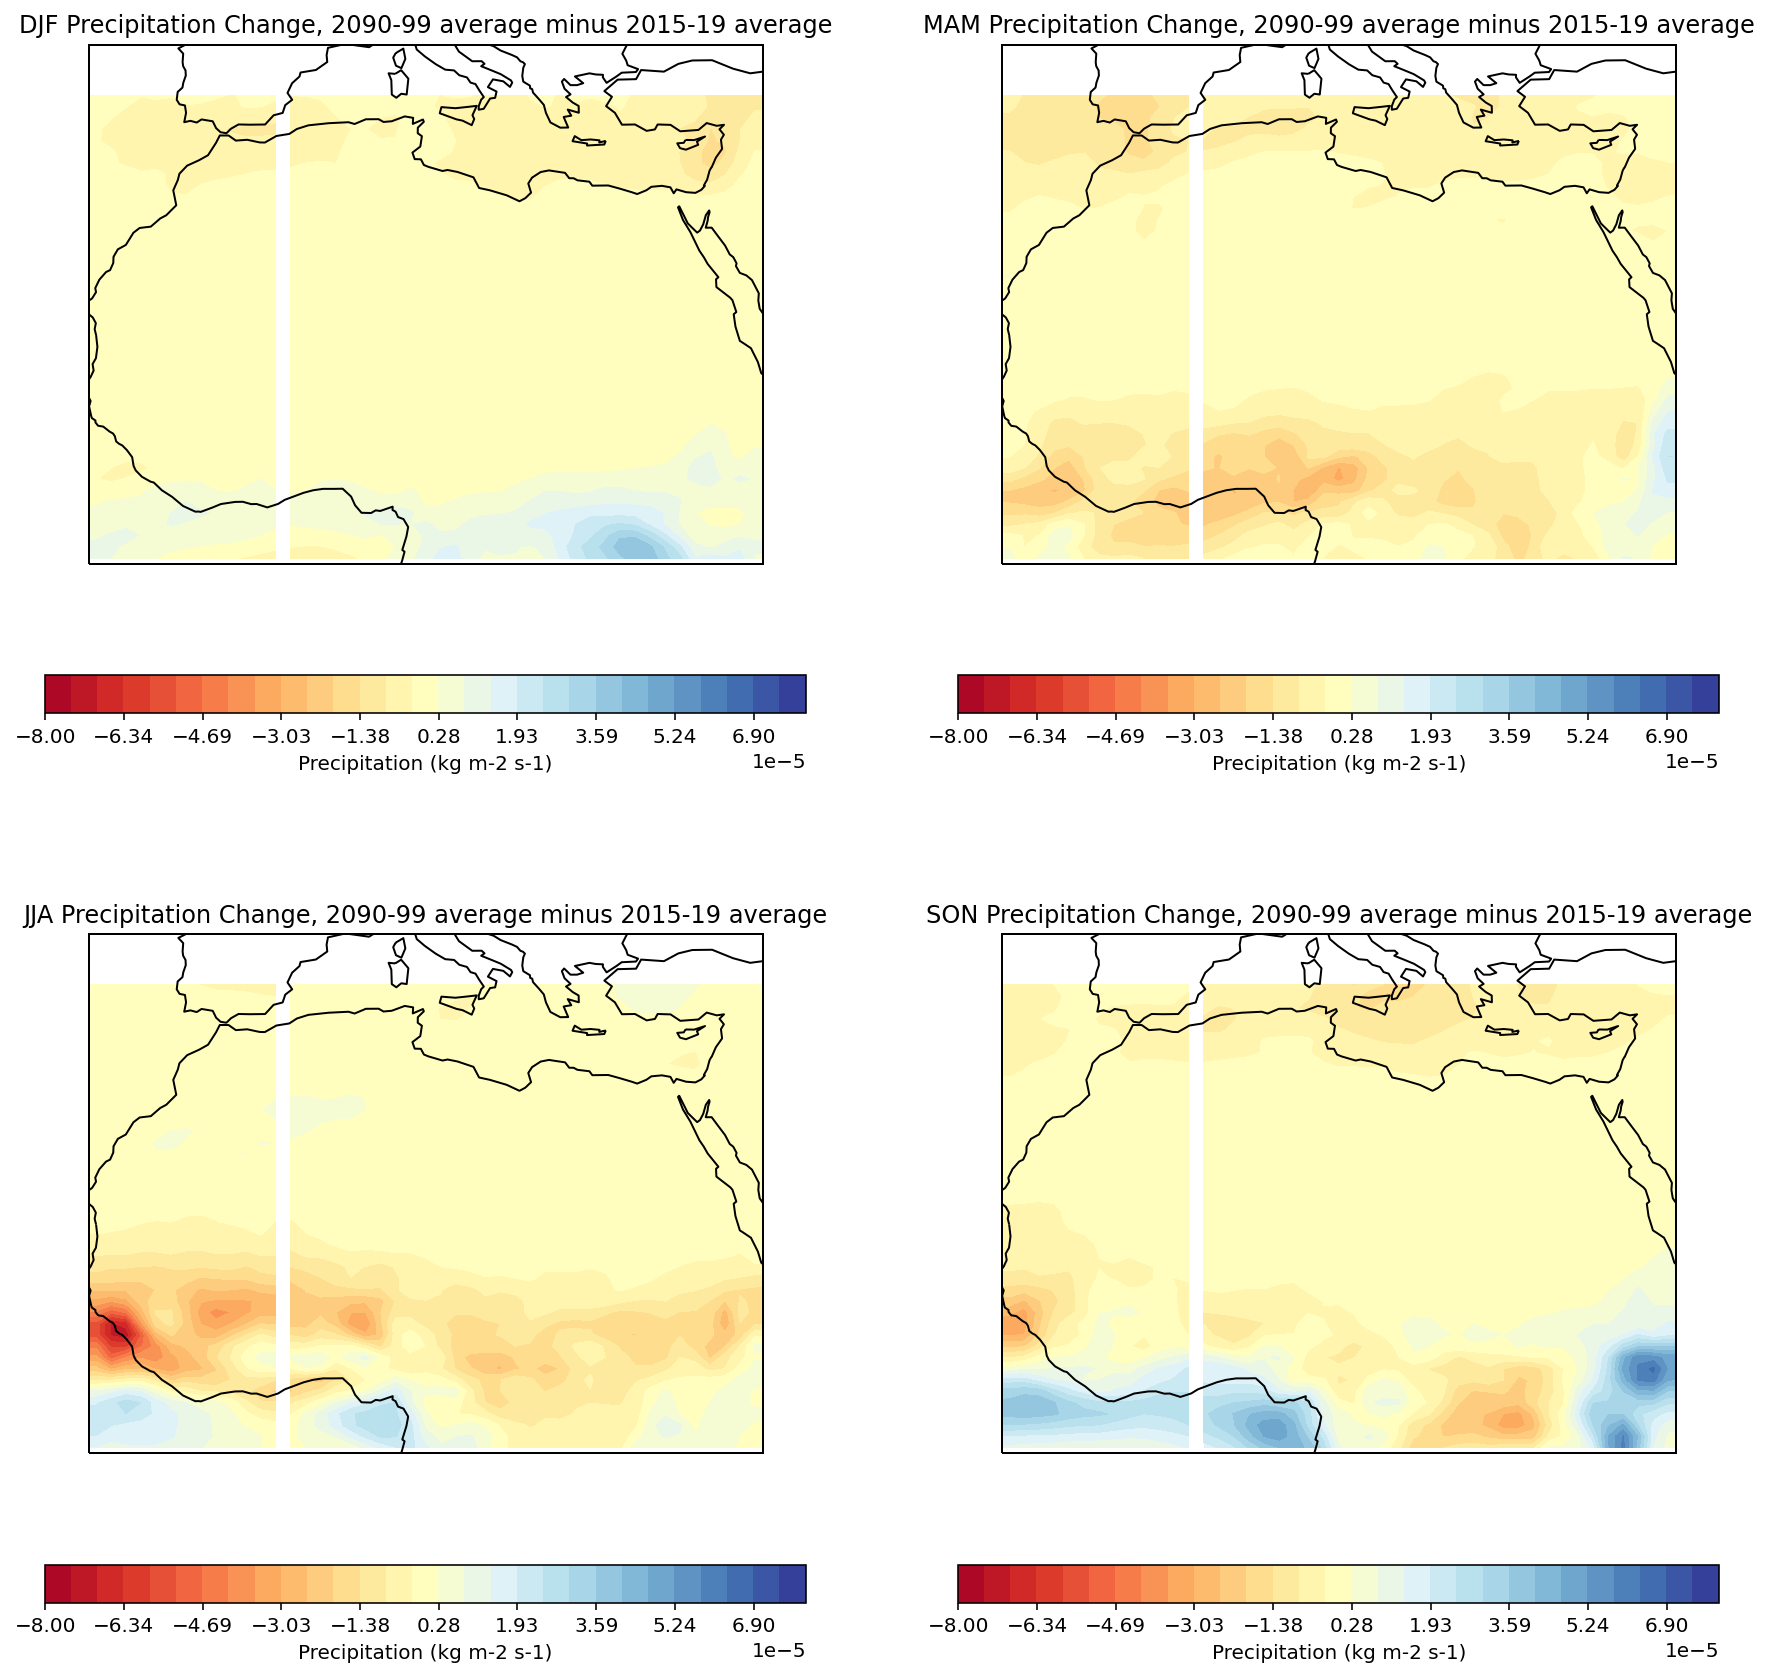

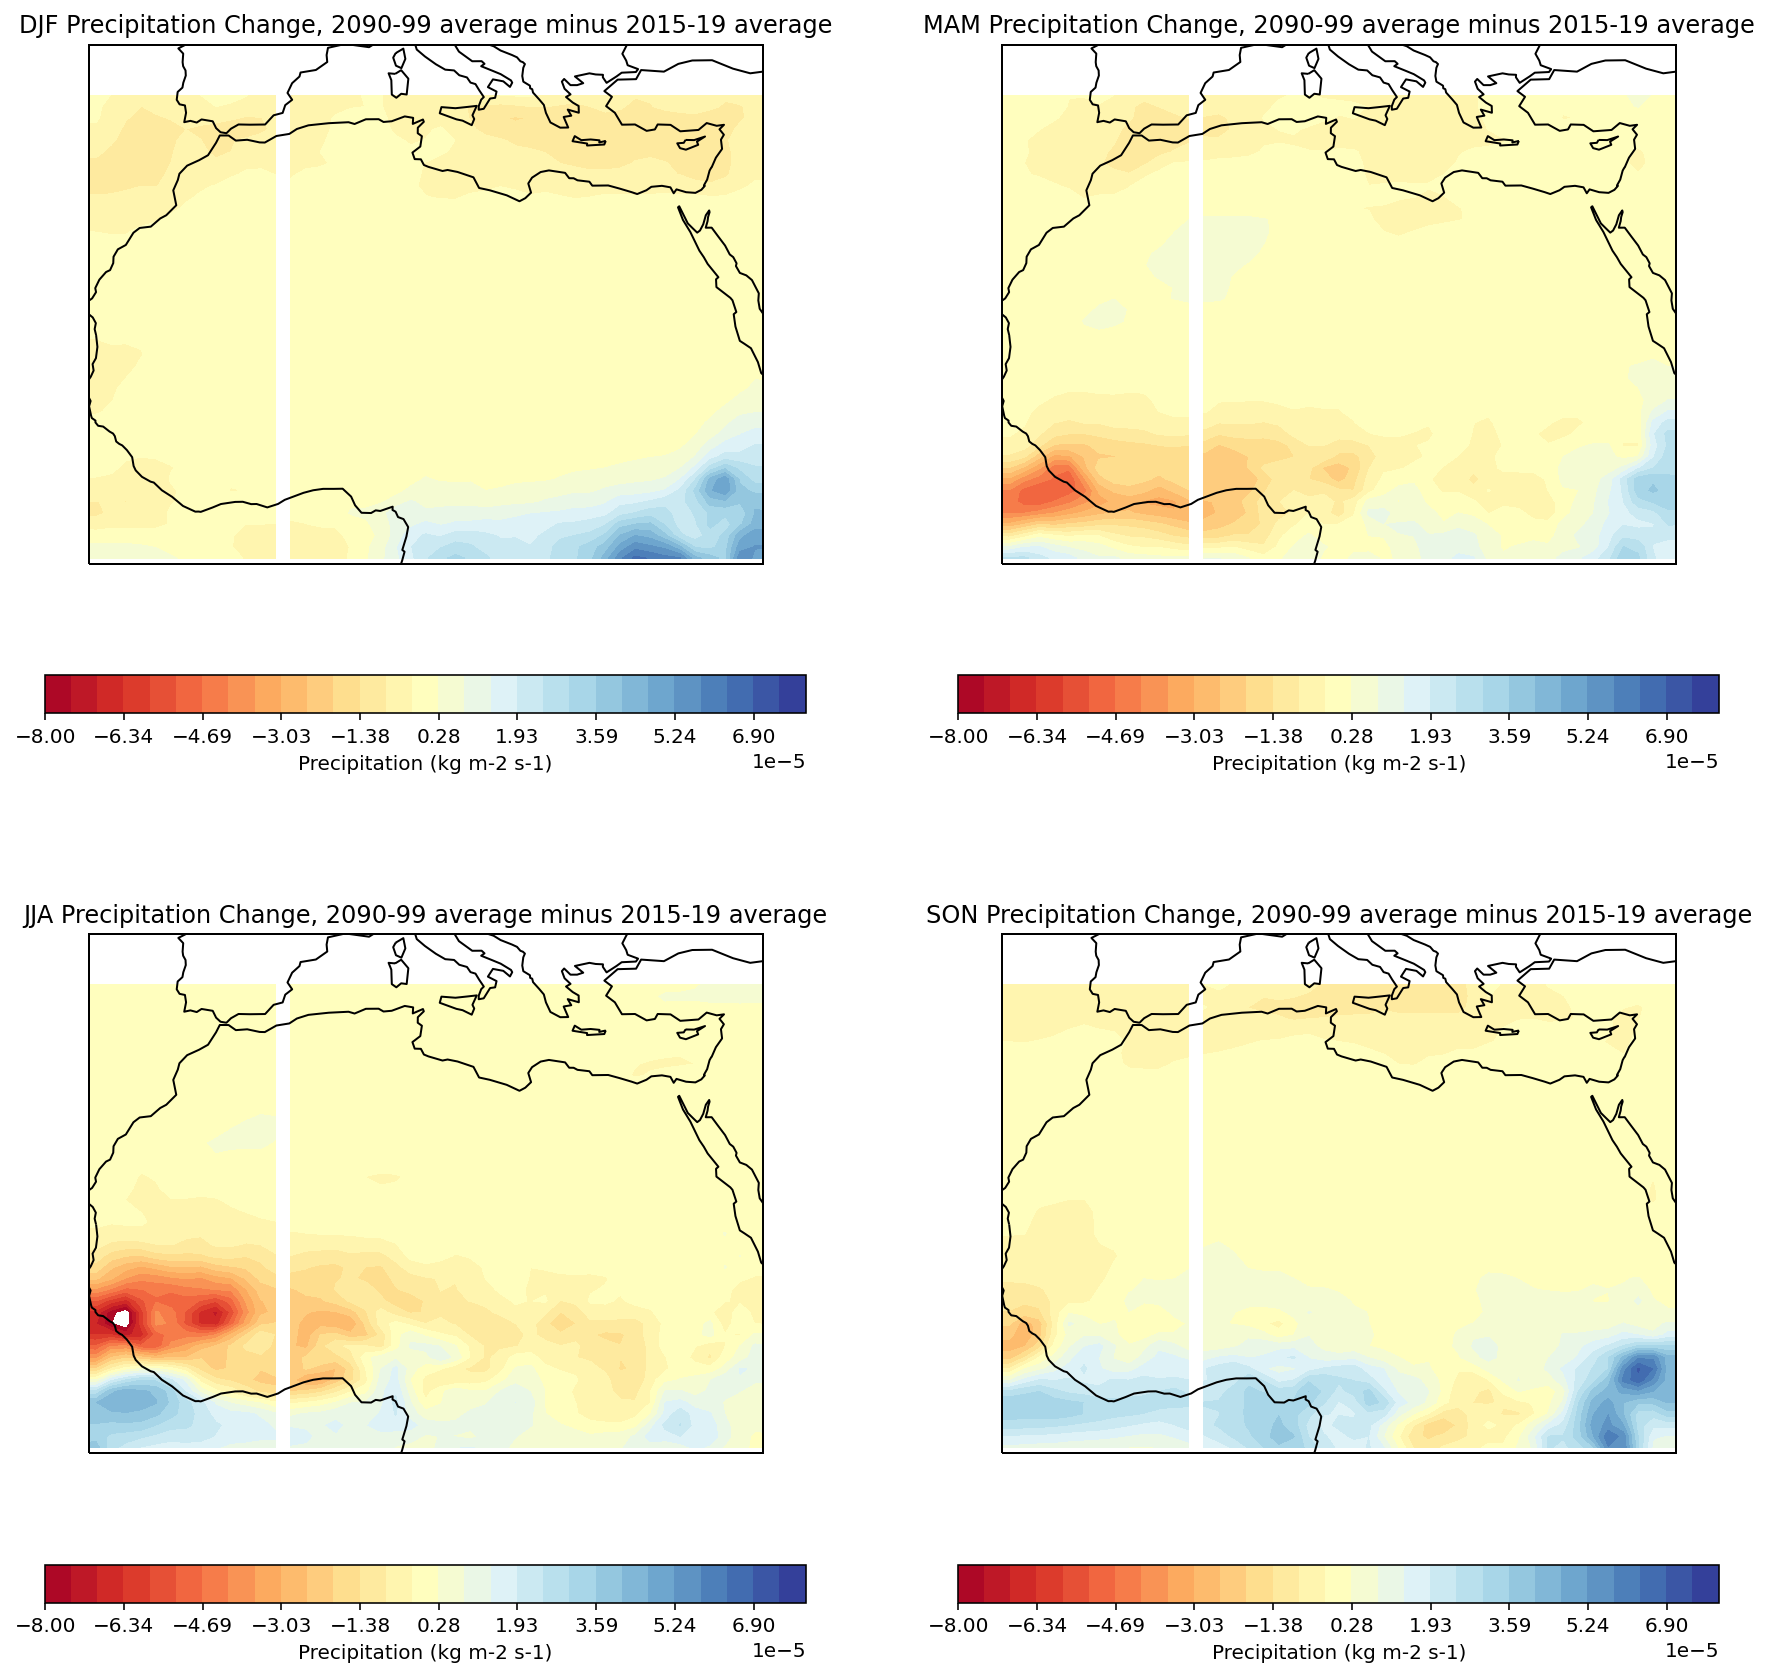

In [5]:
# Mapping the difference between last and first century for each ensemble member individually (just for fun, you probably don't want to actually run this cell for models with many ensemble members)
for ensemble_member in all_maps:
  fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
  axlist = axarr.flatten() # Helpful code: https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
  for i in range(4):
    pr_start = ensemble_member[keyslist[i]][0]
    pr_end = ensemble_member[keyslist[i]][-1]
    diff = pr_end-pr_start

    # maxlist = []
    # minlist = []
    # for j in diff.values:
    #   maxlist.append(np.max(j))
    #   minlist.append(np.min(j))
    # min = np.min(minlist)
    # max = np.max(maxlist)
    
    cmap1 = plt.cm.RdYlBu
    
    levels = np.linspace(-8e-5, 8e-5, 30)
    cs=axlist[i].contourf(lon, lat, diff,levels,
                  transform=ccrs.PlateCarree(),
                  cmap=cmap1)
    axlist[i].coastlines()
    axlist[i].set_extent([-16.88, 39.38, 0, 40]) # longitude latitude extent
    cbar = fig.colorbar(cs, ax=axlist[i], orientation='horizontal') # color map
    cbar.set_label('Precipitation ('+pr.units+')')
    axlist[i].set_title(keyslist[i]+' Precipitation Change, 2090-99 average minus 2015-19 average')
  # plt.savefig(f"{images_dir}/"+experiment_id+"_"+source_id+"_difference_maps.png")
  plt.show()

In [ ]:
# Getting the difference maps for the three ensemble members grouped together for averaging:
diffs = []
for i in range(len(all_maps)):
  diffs.append({})
  for season in keyslist:
    diffs[i][season] = all_maps[i][season][-1] - all_maps[i][season][0]
diffs

In [7]:
# Taking the mean across ensemble members:
all_diffs_values = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}

for season in keyslist:
  arrays = [i[season].values for i in diffs]
  all_diffs_values[season] = np.stack(arrays, axis=0)

all_diffs_avgs = {}
for season in keyslist:
  all_diffs_avgs[season] = all_diffs_values[season].mean(axis=0)

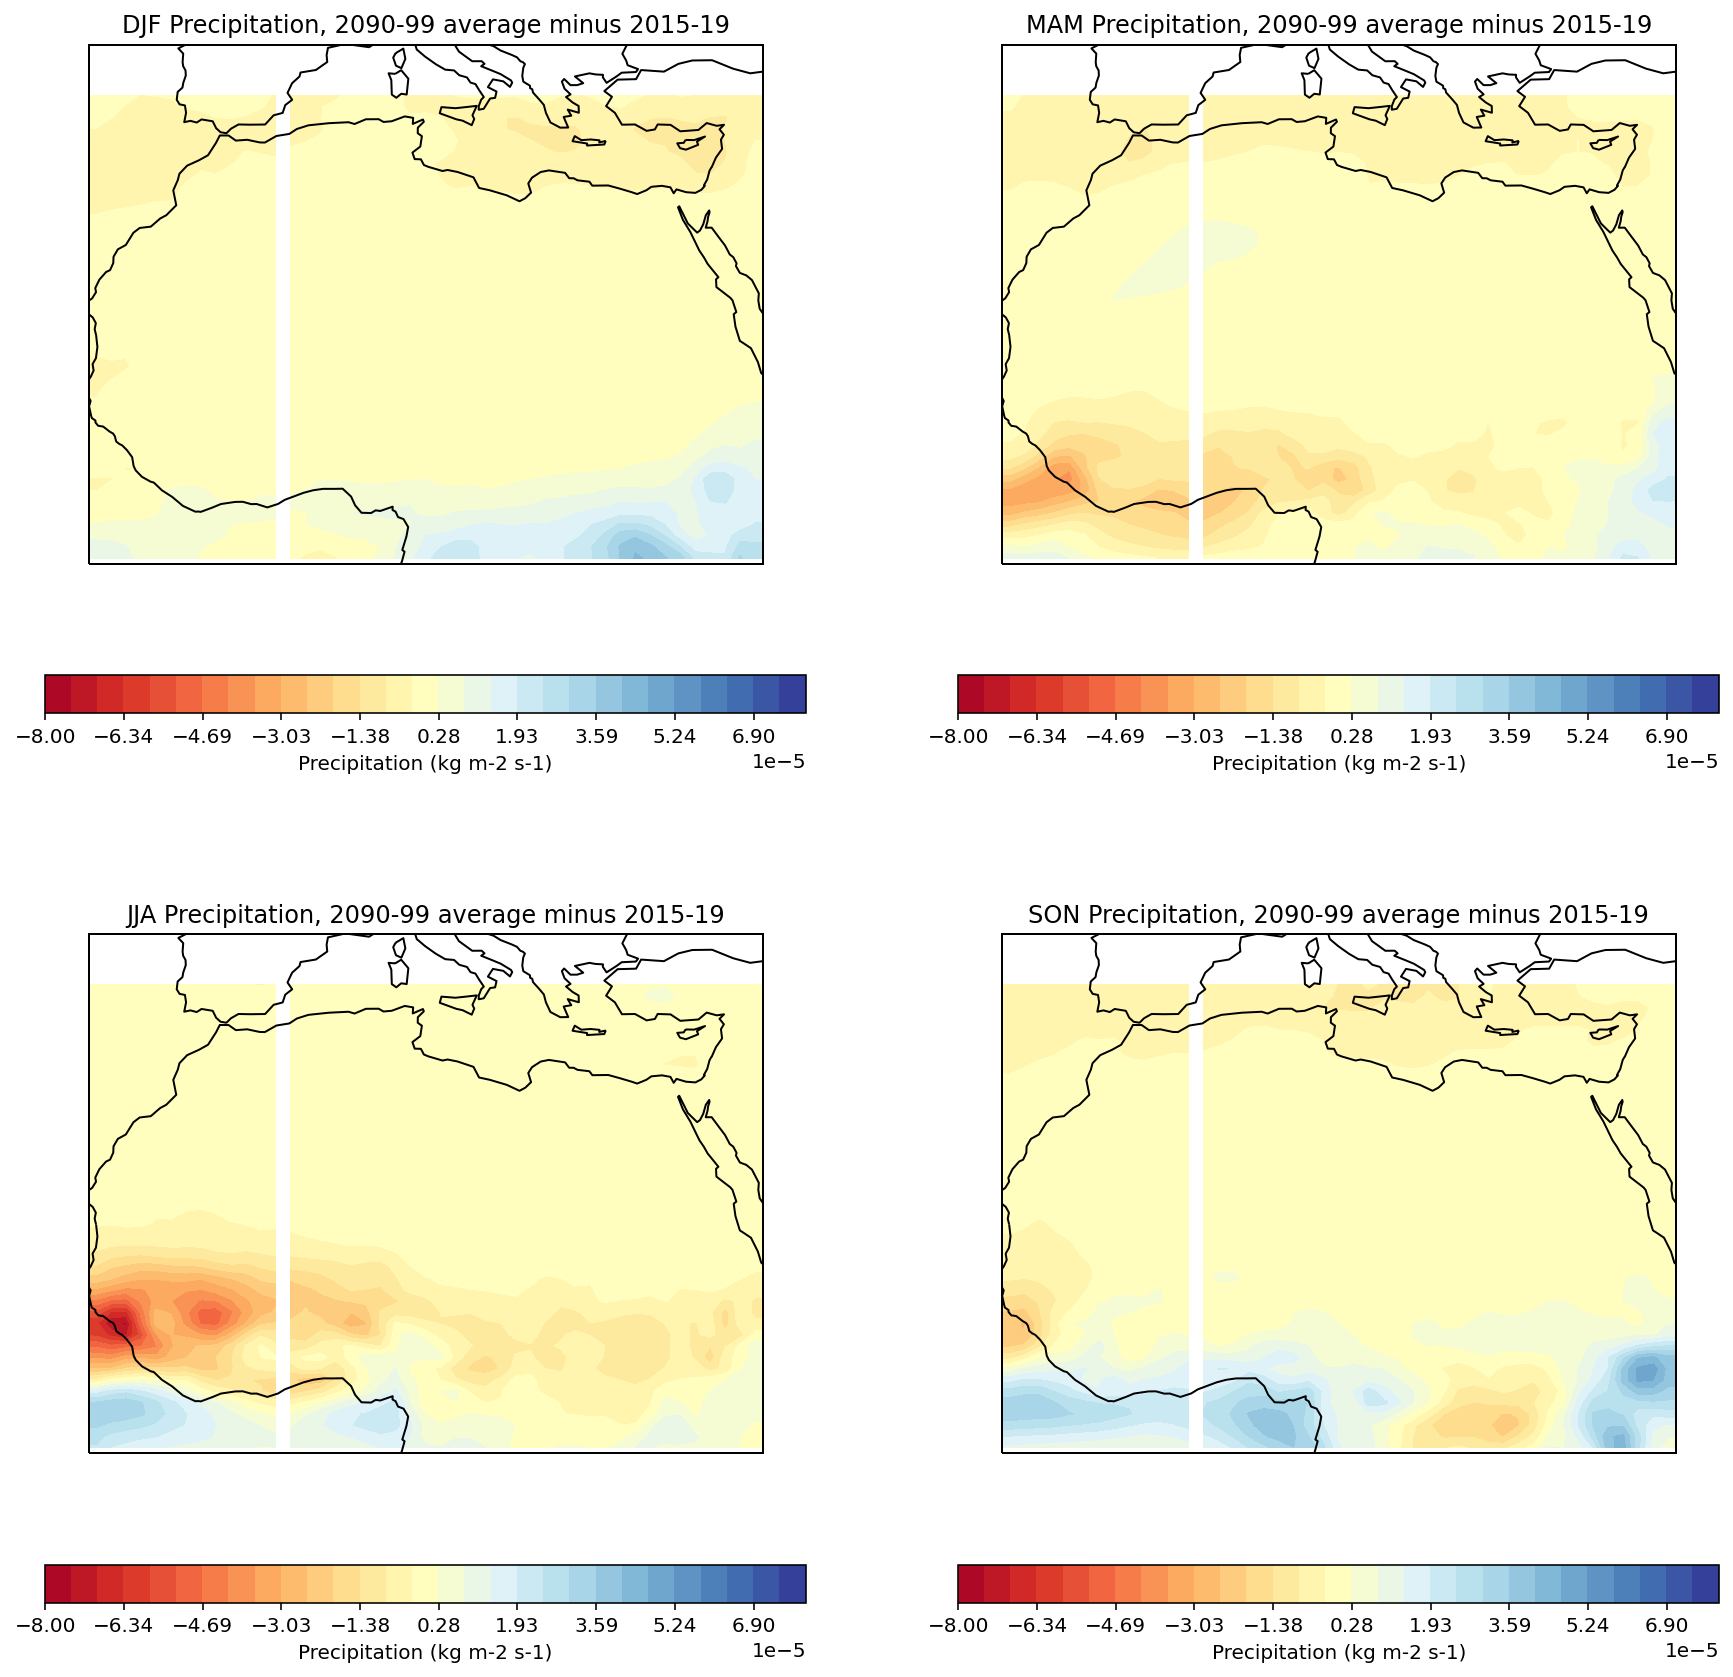

In [8]:
# Plotting the mean across ensemble members:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
axlist = axarr.flatten() # Helpful code: https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
for i in range(4):
  diff = all_diffs_avgs[keyslist[i]]

  # maxlist = []
  # minlist = []
  # for j in diff:
  #   maxlist.append(np.max(j))
  #   minlist.append(np.min(j))
  # min = np.min(minlist)
  # max = np.max(maxlist)
  
  cmap1 = plt.cm.RdYlBu
  
  levels = np.linspace(-8e-5, 8e-5, 30)
  cs=axlist[i].contourf(lon, lat, diff,levels,
                transform=ccrs.PlateCarree(),
                cmap=cmap1)
  axlist[i].coastlines()
  axlist[i].set_extent([-16.88, 39.38, 0, 40]) # longitude latitude extent
  cbar = fig.colorbar(cs, ax=axlist[i], orientation='horizontal') # color map
  cbar.set_label('Precipitation ('+pr.units+')')
  axlist[i].set_title(keyslist[i]+' Precipitation, 2090-99 average minus 2015-19')
# plt.savefig(f"{images_dir}/"+experiment_id+"_"+source_id+"_memnum"+memnum+"_difference_maps.png")
plt.show()